In [1]:
from sklearn.datasets import load_iris

x, t = load_iris(return_X_y=True)
x = x.astype('float32')
t = t.astype('int32')

In [2]:
from chainer.datasets import TupleDataset

dataset = TupleDataset(x, t)

c:\users\arata\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from chainer.datasets import split_dataset_random

train_val, test = split_dataset_random(dataset, int(len(dataset) * 0.7), seed=0)
train, valid = split_dataset_random(train_val, int(len(train_val) * 0.7), seed=0)

In [4]:
from chainer.iterators import SerialIterator

train_iter = SerialIterator(train, batch_size=4, repeat=True, shuffle=True)

minibatch = train_iter.next()

minibatch

[(array([5.5, 2.6, 4.4, 1.2], dtype=float32), 1),
 (array([5.9, 3. , 4.2, 1.5], dtype=float32), 1),
 (array([6.4, 2.8, 5.6, 2.1], dtype=float32), 2),
 (array([6. , 2.2, 5. , 1.5], dtype=float32), 2)]

In [5]:
import chainer
import chainer.links as L
import chainer.functions as F


class Net(chainer.Chain):
    
    def __init__(self, n_in=4, n_hidden=3, n_out=3):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_in, n_hidden)
            self.l2 = L.Linear(n_hidden, n_hidden)
            self.l3 = L.Linear(n_hidden, n_out)

    def forward(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        
        return h

net = Net()

In [6]:
from chainer import optimizers
from chainer.optimizer_hooks import WeightDecay

optimizer = optimizers.MomentumSGD(lr=0.001, momentum=0.9)
optimizer.setup(net)

for param in net.params():
    if param.name != 'b':
        param.update_rule.add_hook(WeightDecay(0.0001))

In [7]:
gpu_id = 0
n_batch = 64
n_epoch = 50

net.to_gpu(gpu_id)

results_train, results_valid = {}, {}
results_train['loss'], results_train['accuracy'] = [], []
results_valid['loss'], results_valid['accuracy'] = [], []

train_iter.reset()

count = 1

for epoch in range(n_epoch):
    while True:
        train_batch = train_iter.next()
        
        x_train, t_train = chainer.dataset.concat_examples(train_batch, gpu_id)
        
        y_train = net(x_train)
        loss_train = F.softmax_cross_entropy(y_train, t_train)
        acc_train = F.accuracy(y_train, t_train)
        
        net.cleargrads()
        loss_train.backward()
        
        optimizer.update()
        
        count += 1
        
        if train_iter.is_new_epoch:
            with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
                x_valid, t_valid = chainer.dataset.concat_examples(valid, gpu_id)
                y_valid = net(x_valid)
                loss_valid = F.softmax_cross_entropy(y_valid, t_valid)
                acc_valid = F.accuracy(y_valid, t_valid)
                
            loss_train.to_cpu()
            loss_valid.to_cpu()
            acc_train.to_cpu()
            acc_valid.to_cpu()
            
            print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f},'
                  'acc (train): {:.4f}, acc (valid): {:.4f}'.format(
                epoch, count, loss_train.array.mean(), loss_valid.array.mean(),
                  acc_train.array.mean(), acc_valid.array.mean()))
            
            results_train['loss'].append(loss_train.array)
            results_train['accuracy'].append(acc_train.array)
            results_valid['loss'].append(loss_valid.array)
            results_valid['accuracy'].append(acc_valid.array)

            break

epoch: 0, iteration: 20, loss (train): 0.9662, loss (valid): 0.9750,acc (train): 1.0000, acc (valid): 0.7188
epoch: 1, iteration: 38, loss (train): 0.8673, loss (valid): 0.8489,acc (train): 0.7500, acc (valid): 0.6562
epoch: 2, iteration: 56, loss (train): 0.6825, loss (valid): 0.8428,acc (train): 0.7500, acc (valid): 0.6562
epoch: 3, iteration: 74, loss (train): 0.8350, loss (valid): 0.7925,acc (train): 0.2500, acc (valid): 0.6562
epoch: 4, iteration: 93, loss (train): 0.5933, loss (valid): 0.7403,acc (train): 1.0000, acc (valid): 0.6562
epoch: 5, iteration: 111, loss (train): 0.8400, loss (valid): 0.7079,acc (train): 0.5000, acc (valid): 0.6562
epoch: 6, iteration: 129, loss (train): 0.6160, loss (valid): 0.6728,acc (train): 0.7500, acc (valid): 0.6562
epoch: 7, iteration: 147, loss (train): 0.5203, loss (valid): 0.6468,acc (train): 0.7500, acc (valid): 0.6562
epoch: 8, iteration: 166, loss (train): 0.9268, loss (valid): 0.6137,acc (train): 0.0000, acc (valid): 0.6562
epoch: 9, itera

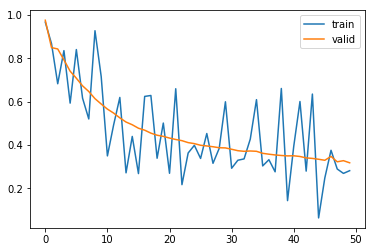

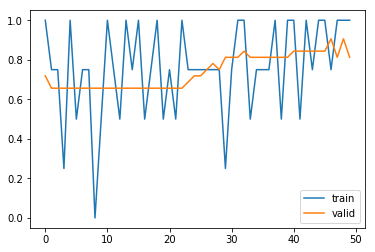

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(results_train['loss'], label='train')
plt.plot(results_valid['loss'], label='valid')
plt.legend()
plt.show()

plt.plot(results_train['accuracy'], label='train')
plt.plot(results_valid['accuracy'], label='valid')
plt.legend()
plt.show()

In [10]:
x_test, t_test = chainer.dataset.concat_examples(test, device=gpu_id)
with chainer.using_config('train', False), chainer.using_config('enable_backdrop', False):
    y_test = net(x_test)
    loss_test = F.softmax_cross_entropy(y_test, t_test)
    acc_test = F.accuracy(y_test, t_test)
    
print('test loss: {:.4f}'.format(loss_test.array.get()))
print('test accuracy: {:.4f}'.format(acc_test.array.get()))

test loss: 0.3127
test accuracy: 0.8889


In [13]:
from chainer.serializers import save_npz

net.to_cpu()

save_npz('net_advanced.npz', net)

In [14]:
!ls

ChainerTutorial_Advanced.ipynb
ChainerTutorial_Standard.ipynb
README.md
my_iris.net
net_advanced.npz


In [15]:
import numpy as np

params = np.load('net_advanced.npz')

for key, param in params.items():
    print(key, ':\t', param.shape)

l3/b :	 (3,)
l3/W :	 (3, 3)
l2/b :	 (3,)
l2/W :	 (3, 3)
l1/b :	 (3,)
l1/W :	 (3, 4)
